# 5. Hafta - Lojistik Regresyon ve Sınıflandırma Hatası Metrikleri

## Giriş

Dahili atalet sensörlü bir akıllı telefon taşırken günlük yaşam aktiviteleri (ADL) yapan çalışma katılımcılarının kayıtlarından oluşturulan [Akıllı Telefonlarla İnsan Aktivitesi Tanıma] veritabanını kullanacağız. (https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)
Amaç, faaliyetleri altı aktiviteden birine (yürüme, yukarı yürüme, aşağı yürüme, oturma, ayakta durma ve yatırma) ayırmaktır.

Alternatif olarak aynı veri seti https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip adresinde bulunabilir.
Eğitim dosyası Human_Activity_Recognition_Using_Smartphones_Data.csv olarak yeniden adlandırılabilir.

Datasetteki her kayıt için: 

- İvmeölçerden üç eksenli hızlanma (toplam hızlanma) ve tahmini vücut ivmesi.
- Üç eksenli Jiroskoptan açısal hız.
- Zaman ve frekans etki alanı değişkenlerine sahip 561 özellikli bir vektör.
- Etkinlik etiketi. 

Özellikler hakkında daha fazla bilgiyi yukarıdaki web sitesinde bulabilirsiniz.

In [ ]:
from __future__ import print_function
import os
#Veri Yolu, sisteminizdeki dosya konumuna göre ayarlanmalıdır
data_path = [os.getcwd()]

In [ ]:
#download the data to the work direictry 
import gdown 

gdown.download("https://drive.google.com/uc?id={0}".format("1nnbelp1ZQZOmoBiStb6E87aHDa_U3B_v"),"Human_Activity_Recognition_Using_Smartphones_Data.csv",quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1nnbelp1ZQZOmoBiStb6E87aHDa_U3B_v
To: /content/Human_Activity_Recognition_Using_Smartphones_Data.csv
70.6MB [00:01, 65.8MB/s]


'Human_Activity_Recognition_Using_Smartphones_Data.csv'

## Soru 1

Verileri içe aktarın ve aşağıdakileri işlemleri uygulayın:

* Veri türlerini inceleyin - çok sayıda sütun var, bu nedenle değer sayılarını kullanmak akıllıca olabilir
* Kayan nokta değerlerinin ölçeklendirilmesi gerekip gerekmediğini belirleyin
* Her faaliyetin dağılımını belirleyin
* Etkinlik etiketini bir integer olarak kodlayın

In [ ]:
import pandas as pd
import numpy as np
#Dosya yolu, önceki hücrede ayarlanan data_path'e bağlıdır
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

Veri sütunları, etkinlik etiketi dışındaki tüm öğelerdir.

In [ ]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [ ]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

Verilerin tümü -1 (minimum) ile 1,0 (maksimum) arasında ölçeklendirilir.

In [ ]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [ ]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Faaliyetlerin dökümünü inceleyin - nispeten dengelidirler.

In [ ]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

In [ ]:
type(data.Activity)

pandas.core.series.Series

Scikit öğrenme sınıflandırıcıları, tahmin sütunu için seyrek bir matrisi kabul etmez. Bu nedenle, etkinlik etiketlerini interger'a dönüştürmek için ya “LabelEncoder” kullanılmalıdır ya da “DictVectorizer” kullanılmalıdır, sonuçta ortaya çıkan matrisin seyrek olmayan bir diziye dönüştürülmesi gerekir. 
"Activity" sütununa sığdırmak için `LabelEncoder` kullanın ve 5 rastgele değere bakın.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)

data['Activity'].sample(5)

5970    0
4968    0
365     2
7747    3
4333    4
Name: Activity, dtype: int64

In [ ]:
data.Activity

0        2
1        2
2        2
3        2
4        2
        ..
10294    5
10295    5
10296    5
10297    5
10298    5
Name: Activity, Length: 10299, dtype: int64

## Soru 2

* Bağımlı değişkenler arasındaki korelasyonları hesaplayın.
* Korelasyon değerlerinin histogramını oluşturun.
* En fazla korelasyonlu olanları tanımlayın (pozitif veya negatif).

In [ ]:
# Korelasyon değerlerini hesaplama
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Köşegen altındaki tüm verileri boşaltarak basitleştirin
tril_index = np.tril_indices_from(corr_values)

# Kullanılmayan değerleri NaN yapın|
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Verileri istifleyin ve dataframe'e dönüştürün
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Sıralama için mutlak değerleri alın
corr_values['abs_correlation'] = corr_values.correlation.abs()

Mutlak değer korelasyonlarının bir histogramı.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


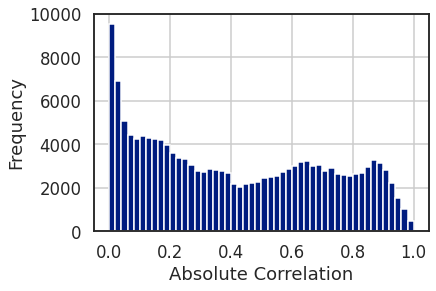

In [ ]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [ ]:
# En yüksek korelasyon değerleri
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


In [ ]:
data.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
tBodyAcc-mean()-X,0.288585,0.278419,0.279653,0.279174,0.276629,0.277199,0.279454,0.277432,0.277293,0.280586,0.276880,0.276228,0.278457,0.277175,0.297946,0.279203,0.279038,0.280135,0.277731,0.275568
tBodyAcc-mean()-Y,-0.020294,-0.016411,-0.019467,-0.026201,-0.016570,-0.010098,-0.019641,-0.030488,-0.021751,-0.009960,-0.012722,-0.021441,-0.020415,-0.014713,0.027094,-0.023020,-0.014800,-0.013917,-0.018211,-0.016980
tBodyAcc-mean()-Z,-0.132905,-0.123520,-0.113462,-0.123283,-0.115362,-0.105137,-0.110022,-0.125360,-0.120751,-0.106065,-0.103438,-0.108202,-0.112732,-0.106756,-0.061668,-0.122080,-0.116849,-0.106370,-0.109188,-0.111429
tBodyAcc-std()-X,-0.995279,-0.998245,-0.995380,-0.996091,-0.998139,-0.997335,-0.996921,-0.996559,-0.997328,-0.994803,-0.994815,-0.998246,-0.999135,-0.999188,-0.988641,-0.996839,-0.996941,-0.997695,-0.997491,-0.997811
tBodyAcc-std()-Y,-0.983111,-0.975300,-0.967187,-0.983403,-0.980817,-0.990487,-0.967186,-0.966728,-0.961245,-0.972758,-0.973077,-0.987214,-0.984680,-0.990526,-0.816699,-0.974848,-0.981866,-0.987516,-0.993222,-0.990522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroJerkMean,gravityMean)",-0.018446,0.703511,0.808529,-0.485366,-0.615971,-0.368224,-0.189512,0.467383,0.117797,-0.070670,0.115931,-0.651945,0.765485,0.498814,-0.268791,-0.056927,-0.229155,0.367557,0.788193,-0.411729
"angle(X,gravityMean)",-0.841247,-0.844788,-0.848933,-0.848649,-0.847865,-0.849632,-0.852150,-0.851017,-0.847971,-0.848294,-0.851562,-0.852723,-0.850654,-0.849773,-0.730937,-0.761101,-0.759172,-0.759363,-0.761052,-0.760620
"angle(Y,gravityMean)",0.179941,0.180289,0.180637,0.181935,0.185151,0.184823,0.182170,0.183779,0.188982,0.190310,0.187609,0.186050,0.187611,0.188812,0.283159,0.263119,0.264324,0.264033,0.262886,0.263169
"angle(Z,gravityMean)",-0.058627,-0.054317,-0.049118,-0.047663,-0.043892,-0.042126,-0.043010,-0.041976,-0.037364,-0.034417,-0.034681,-0.035852,-0.035998,-0.035063,0.036444,0.024172,0.027014,0.029664,0.029346,0.029573


## Soru 3

* Verileri eğitim ve test verisetine ayırın. Bu, herhangi bir yöntem kullanılarak yapılabilir, ancak aynı öngörücü sınıf oranını korumak için Scikit-learn'un `StratifiedShuffleSplit`'i kullanmayı deneyin.
* Verileri bölmek için kullanılan yöntemlerden bağımsız olarak, hem eğitim hem de test bölümlerindeki sınıfların oranını karşılaştırın.


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split

# Bölünmüş dizinleri alın
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Dataframe oluşturma
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [ ]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Soru 4

* Tüm özellikleri kullanarak herhangi bir düzenleme yapmadan lojistik regresyon modelini uygulayın. Katsayı çıktısını anlayabilmeniz için çok sınıflı bir modelin uygulanmasıyla ilgili belgeleri mutlaka okuyun. Modeli depolayın.
* Hiperparametreleri belirlemek için çapraz doğrulamayı kullanarak, L1 ve L2 regülarizasyonu kullanarak modelleri uygulayın. Bu modellerin her birini de depolayın. Çok sınıflı modeller(multi-class models), çözücüler(solvers) ve düzenlemelerdeki(regularizations) sınırlamalara dikkat edin.  Düzenli modeller, özellikle L1 modeli, muhtemelen uygulanması biraz zaman alacaktır.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Standart lojistik regresyon
lr = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#Calculating Details for lr Model
print('lr Model Train Score is : ' , lr.score(X_train, y_train))
print('lr Model Test Score is : ' , lr.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr.predict(X_test)
print('Predicted Value for lr Model is : ' , y_pred[:10])


lr Model Train Score is :  0.9877930364821751
lr Model Test Score is :  0.9802588996763754
----------------------------------------------------
Predicted Value for lr Model is :  [3 5 3 1 0 5 0 2 0 0]


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [ ]:
#Calculating Details for lr_l1 Model
print('lr_l1 Model Train Score is : ' , lr_l1.score(X_train, y_train))
print('lr_l1 Model Test Score is : ' , lr_l1.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l1.predict(X_test)
print('Predicted Value for lr_l1 Model is : ' , y_pred[:10])

lr_l1 Model Train Score is :  0.9929255097794424
lr_l1 Model Test Score is :  0.9841423948220065
----------------------------------------------------
Predicted Value for lr_l1 Model is :  [3 5 3 1 0 5 0 2 0 0]


In [ ]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
#Calculating Details for lr_l2 Model
print('lr_l2 Model Train Score is : ' , lr_l2.score(X_train, y_train))
print('lr_l2 Model Test Score is : ' , lr_l2.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2.predict(X_test)
print('Predicted Value for lr_l2 Model is : ' , y_pred[:10])

lr_l2 Model Train Score is :  0.9986128450547926
lr_l2 Model Test Score is :  0.984789644012945
----------------------------------------------------
Predicted Value for lr_l2 Model is :  [3 5 3 1 0 5 0 2 0 0]


In [ ]:
# "Newton-cg", "lbfgs", "sag", "saga" gibi farklı çözücülerle deneyin ve gözlemlerinizi paylaşın

In [ ]:
#penalty='l2', solver='newton-cg'
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2_newton_cg = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg').fit(X_train, y_train)

In [ ]:
#Calculating Details for lr_l2_newton_cg Model
print('lr_l2_newton_cg Model Train Score is : ' , lr_l2_newton_cg.score(X_train, y_train))
print('lr_l2_newton_cg Model Test Score is : ' , lr_l2_newton_cg.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_newton_cg.predict(X_test)
print('Predicted Value for lr_l2_newton_cg Model is : ' , y_pred[:10])

lr_l2_newton_cg Model Train Score is :  0.9944513802191705
lr_l2_newton_cg Model Test Score is :  0.983495145631068
----------------------------------------------------
Predicted Value for lr_l2_newton_cg Model is :  [3 5 3 1 0 5 0 2 0 0]


In [ ]:
#penalty='l2', solver='lbfgs'
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l2_lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs').fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
#Calculating Details for lr_l2_lbfgs Model
print('lr_l2_lbfgs Model Train Score is : ' , lr_l2_lbfgs.score(X_train, y_train))
print('lr_l2_lbfgs Model Test Score is : ' , lr_l2_lbfgs.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_newton_cg.predict(X_test)
print('Predicted Value for lr_l2_lbfgs Model is : ' , y_pred[:10])

lr_l2_lbfgs Model Train Score is :  0.9986128450547926
lr_l2_lbfgs Model Test Score is :  0.984789644012945
----------------------------------------------------
Predicted Value for lr_l2_lbfgs Model is :  [3 5 3 1 0 5 0 2 0 0]


In [ ]:
#penalty='l2', solver='sag'
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag').fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [ ]:
#Calculating Details for lr_l2_sag Model
print('lr_l2_sag Model Train Score is : ' , lr_l2_sag.score(X_train, y_train))
print('lr_l2_sag Model Test Score is : ' , lr_l2_sag.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_sag.predict(X_test)
print('Predicted Value for lr_l2_lbfgs Model is : ' , y_pred[:10])

lr_l2_sag Model Train Score is :  0.9959772506588986
lr_l2_sag Model Test Score is :  0.9854368932038835
----------------------------------------------------
Predicted Value for lr_l2_lbfgs Model is :  [3 5 3 1 0 5 0 2 0 0]


In [ ]:
#penalty='l1', solver='saga'
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1_saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [ ]:
#Calculating Details for lr_l1_saga Model
print('lr_l1_saga Model Train Score is : ' , lr_l1_saga.score(X_train, y_train))
print('lr_l1_saga Model Test Score is : ' , lr_l1_saga.score(X_test, y_test))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l1_saga.predict(X_test)
print('Predicted Value for lr_l2_lbfgs Model is : ' , y_pred[:10])

lr_l1_saga Model Train Score is :  0.9945900957136912
lr_l1_saga Model Test Score is :  0.9841423948220065
----------------------------------------------------
Predicted Value for lr_l2_lbfgs Model is :  [3 5 3 1 0 5 0 2 0 0]


## Soru 5

Her model için katsayıların büyüklüklerini karşılaştırın. one-vs-rest fitting bağlantısı kullanılmışsa, her bir katsayı seti ayrı olarak çizilebilir.

In [ ]:
# Tüm katsayıları bir dataframe'de birleştirin 
coefficients = list()

#coeff_labels = ['lr', 'l1', 'l2']
#coeff_models = [lr, lr_l1, lr_l2]

coeff_labels = ['lr', 'l1', 'l2'   , 'lr_l2_newton_cg' , 'lr_l2_lbfgs' , 'lr_l2_sag' , 'lr_l1_saga']
coeff_models = [ lr , lr_l1, lr_l2 ,  lr_l2_newton_cg  , lr_l2_lbfgs   ,  lr_l2_sag  ,  lr_l1_saga]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10).T


162       213       560  ...       384       230       106
lr              0  0.008229 -0.040974 -0.162261  ... -0.042385 -0.080276 -0.174918
                1  0.060884 -0.146766 -0.310705  ...  0.018112  0.014172  0.212082
                2 -0.026952 -0.096860  0.280090  ...  0.051356 -0.071702  0.105605
                3  0.194104  0.065221  0.091811  ... -0.007624  0.122316  0.125495
                4  0.036810 -0.030604 -0.137545  ...  0.047612 -0.232848 -0.373654
                5 -0.273074  0.249984  0.238610  ... -0.067072  0.248338  0.105390
l1              0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
                1  0.000000 -0.680757  0.000000  ...  0.000000  0.000000  0.166136
                2  0.000000 -0.050462  0.000000  ...  0.000000  0.000000 -0.333705
                3  0.931782  0.000000  0.000000  ...  0.111332  0.000000 -0.586197
                4  0.000000 -1.459512  0.000000  ...  0.000000  0.000000 -3.383587
                5 -0.682902  0.000000  1.406794  ... -0.046433  0.322384  0.000000
l2              0 -0.051440  0.077191 -0.408020  ... -0.238472 -0.256407 -0.631867
                1  3.200249 -0.654219 -0.645041  ...  0.053764  1.543027  5.337975
                2 -3.206736 -0.129240  0.821438  ...  0.329389 -1.539273 -4.178106
                3  0.546467  0.234898  0.141383  ...  0.155720  0.273726  0.074176
                4  0.285088 -0.216820 -0.453446  ... -0.089531 -0.730967 -0.947805
                5 -0.773629  0.688190  0.543686  ... -0.210870  0.709895  0.345626
lr_l2_newton_cg 0  0.008601  0.014560 -0.254004  ... -0.010289 -0.029380 -0.220703
                1  0.374144 -0.227759 -0.200738  ... -0.017963  0.174152  0.901071
                2 -0.382896  0.026622  0.372484  ... -0.009843 -0.319917 -0.421667
                3  0.240557  0.058083  0.077407  ...  0.084040  0.125018  0.026767
                4  0.112671 -0.130125 -0.216371  ...  0.010388 -0.256980 -0.441148
                5 -0.353078  0.258619  0.221222  ... -0.056333  0.307107  0.155680
lr_l2_lbfgs     0 -0.051440  0.077191 -0.408020  ... -0.238472 -0.256407 -0.631867
                1  3.200249 -0.654219 -0.645041  ...  0.053764  1.543027  5.337975
                2 -3.206736 -0.129240  0.821438  ...  0.329389 -1.539273 -4.178106
                3  0.546467  0.234898  0.141383  ...  0.155720  0.273726  0.074176
                4  0.285088 -0.216820 -0.453446  ... -0.089531 -0.730967 -0.947805
                5 -0.773629  0.688190  0.543686  ... -0.210870  0.709895  0.345626
lr_l2_sag       0  0.008664  0.035452 -0.332141  ... -0.104816 -0.116142 -0.269304
                1  0.472845 -0.317320 -0.283893  ...  0.012868  0.281345  1.265104
                2 -0.458796 -0.010320  0.503705  ...  0.118467 -0.360486 -0.648418
                3  0.332577  0.086455  0.101423  ...  0.093352  0.184271  0.036004
                4  0.130158 -0.157465 -0.279840  ...  0.000809 -0.410085 -0.597697
                5 -0.485448  0.363198  0.290747  ... -0.120680  0.421096  0.214312
lr_l1_saga      0  0.004883  0.023006 -0.086934  ... -0.065405 -0.066179 -0.148683
                1  0.209280 -0.177617 -0.194945  ... -0.003586  0.154088  0.819453
                2 -0.208494  0.029763  0.309087  ...  0.068797 -0.145855 -0.388001
                3  0.243535  0.023694  0.044060  ...  0.082704  0.070486  0.016104
                4  0.111318 -0.073522 -0.140844  ...  0.007807 -0.222669 -0.434496
                5 -0.406355  0.213274  0.125695  ... -0.114380  0.277877  0.099186

[42 rows x 10 columns]

Çok sınıflı katsayıların her biri için altı ayrı çizim hazırlayın.

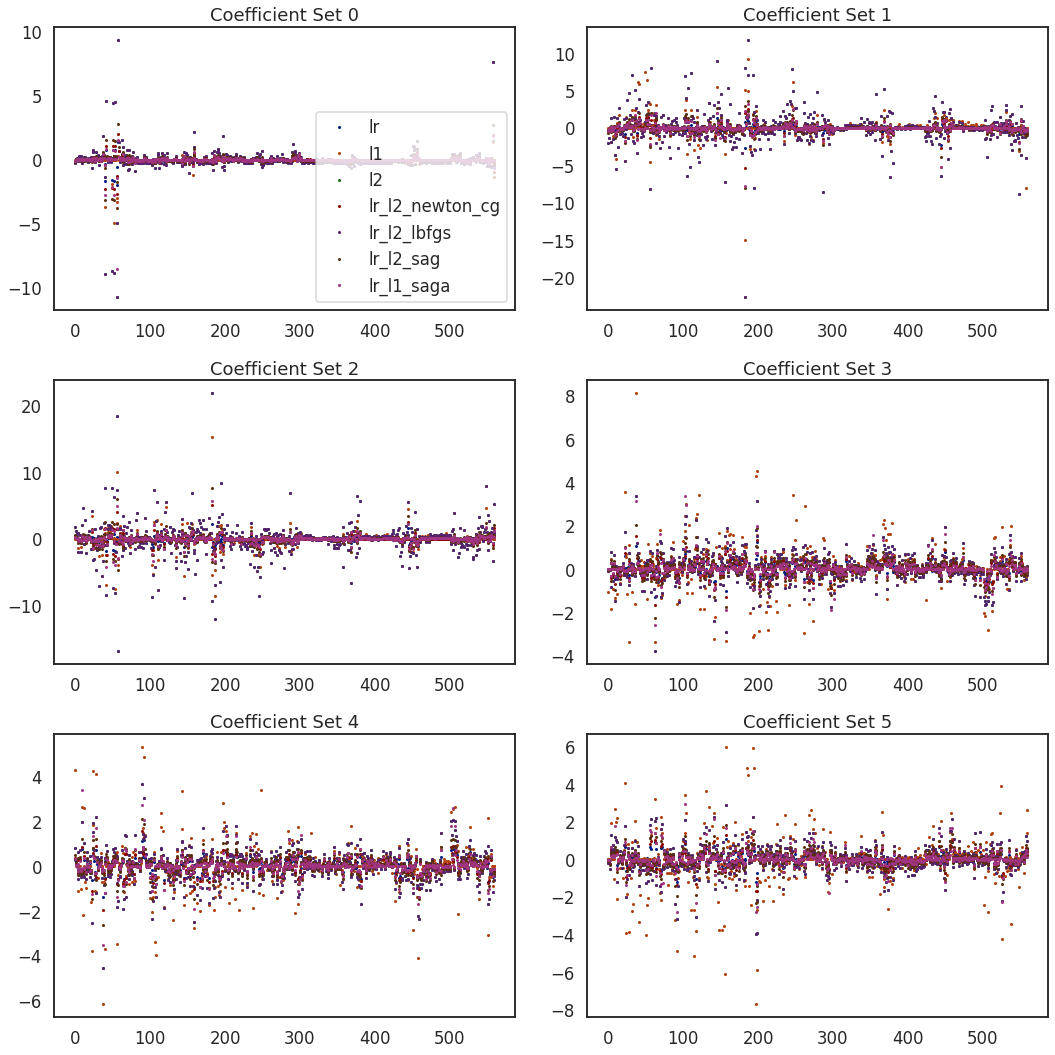

In [ ]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(15,15)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Soru 6

* Her model için sınıfı tahmin edin ve depolayın.
* Ayrıca her bir model için öngörülen sınıf olasılığını da depolayın.

In [ ]:
# Sınıfı ve her birinin olasılığını tahmin edin

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2'   , 'lr_l2_newton_cg' , 'lr_l2_lbfgs' , 'lr_l2_sag' , 'lr_l1_saga']
coeff_models = [ lr , lr_l1, lr_l2 ,  lr_l2_newton_cg  , lr_l2_lbfgs   ,  lr_l2_sag  ,  lr_l1_saga]
for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2,lr_l2_newton_cg,lr_l2_lbfgs,lr_l2_sag,lr_l1_saga
0,3,3,3,3,3,3,3
1,5,5,5,5,5,5,5
2,3,3,3,3,3,3,3
3,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0


In [ ]:
y_prob.head()

,lr,l1,l2,lr_l2_newton_cg,lr_l2_lbfgs,lr_l2_sag,lr_l1_saga
0,0.999995,0.998972,1.0,0.999999,1.0,1.000000,1.000000
1,0.999237,0.999542,1.0,0.999650,1.0,0.999985,0.999976
2,0.997399,0.995381,1.0,0.998874,1.0,0.999896,0.999879
3,0.988780,0.999187,1.0,0.997837,1.0,0.999828,0.999621
4,0.995022,0.999921,1.0,0.999326,1.0,0.999907,0.999626


## Soru 7

Her model için aşağıdaki hata metriklerini hesaplayın:

* accuracy
* precision
* recall
* fscore
* confusion matrix

Çok modelli metrikleri her model için nasıl tek bir değerde birleştireceğinize karar verin.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Çok sınıflı destek fonksiyonunda Precision, recall, f-score 
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # accuracy'yi hesaplamanın olağan yolu
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC skorları verilerin ikilileştirilmesi(binarizing) ile hesaplanabilir
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Son olarak, confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [ ]:
# Metrikleri çalıştırın
metrics

,lr,l1,l2,lr_l2_newton_cg,lr_l2_lbfgs,lr_l2_sag,lr_l1_saga
precision,0.980246,0.984153,0.984806,0.983485,0.984806,0.985443,0.984133
recall,0.980259,0.984142,0.984790,0.983495,0.984790,0.985437,0.984142
fscore,0.980248,0.984140,0.984786,0.983488,0.984786,0.985436,0.984135
accuracy,0.980259,0.984142,0.984790,0.983495,0.984790,0.985437,0.984142
auc,0.988042,0.990342,0.990744,0.989983,0.990744,0.991146,0.990358


## Soru 8

Her model için karışıklık matrisini görüntüleyin veya görselleştirin.

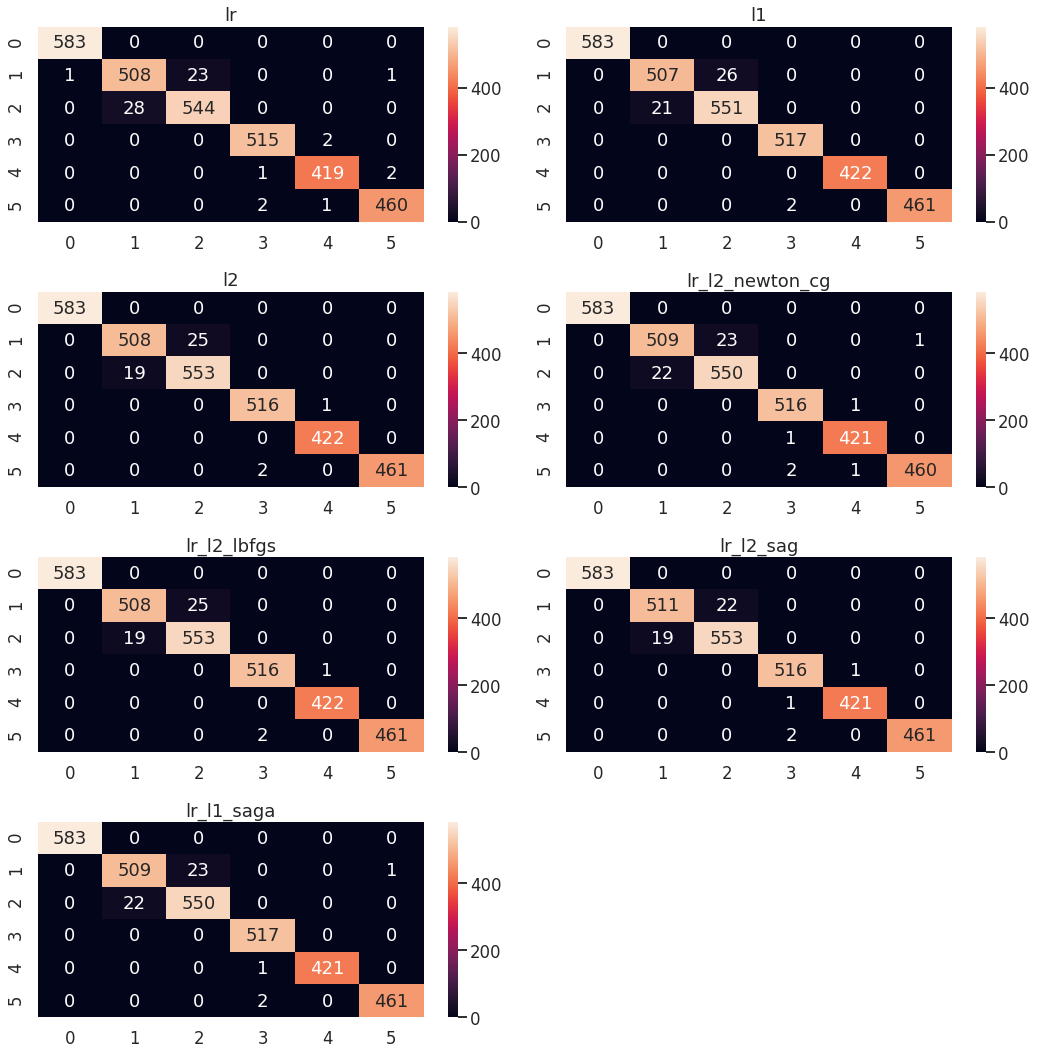

In [ ]:

fig, axList = plt.subplots(nrows=4, ncols=2)
axList = axList.flatten()
fig.set_size_inches(15, 15)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## Soru 9
Yüksek ilişkili sütunları belirleyin ve model oluşturmadan önce bu sütunları kaldırın.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold

#threshold with .7

sel = VarianceThreshold(threshold=(.7 * (1 - .7)))

data2 = pd.concat([X_train,X_test])
data_new = pd.DataFrame(sel.fit_transform(data2))


data_y = pd.concat([y_train,y_test])

from sklearn.model_selection import train_test_split

X_new,X_test_new = train_test_split(data_new)
Y_new,Y_test_new = train_test_split(data_y)

İlişkili sütunları kaldırdıktan sonra yeni eğitim verileriyle tekrar model oluşturun

In [ ]:
# Standart, L1 ve L2 Lojistik regresyonunu deneyin

In [ ]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr_1 = LogisticRegression().fit(X_new, Y_new)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#Calculating Details for lr1 Model
print('lr_1 Train Score is : ' , lr_1.score(X_new, Y_new))
print('lr_1 Test Score is : ' , lr_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_1.predict(X_test_new)
print('Predicted Value for lr_1 Model is : ' , y_pred[:10])

lr_1 Train Score is :  0.2127136198860694
lr_1 Test Score is :  0.17902912621359224
----------------------------------------------------
Predicted Value for lr_1 Model is :  [0 0 0 0 0 0 3 1 0 2]


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg').fit(X_new, Y_new)

In [ ]:
#Calculating Details for lr_l1_1 Model
print('lr_l1_1 Model Train Score is : ' , lr_l1_1.score(X_new, Y_new))
print('lr_l1_1 Model Test Score is : ' , lr_l1_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l1_1.predict(X_test_new)
print('Predicted Value for lr_l1_1 Model is : ' , y_pred[:10])

lr_l1_1 Model Train Score is :  0.19665976178146038
lr_l1_1 Model Test Score is :  0.1833009708737864
----------------------------------------------------
Predicted Value for lr_l1_1 Model is :  [0 0 0 0 0 0 0 0 0 0]


In [ ]:
# L2 regularized logistic regression
lr_l2_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2').fit(X_new, Y_new)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
#Calculating Details for lr_l2_1 Model
print('lr_l2_1 Model Train Score is : ' , lr_l2_1.score(X_new, Y_new))
print('lr_l2_1 Model Test Score is : ' , lr_l2_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_1.predict(X_test_new)
print('Predicted Value for lr_l2_1 Model is : ' , y_pred[:10])

lr_l2_1 Model Train Score is :  0.19665976178146038
lr_l2_1 Model Test Score is :  0.1833009708737864
----------------------------------------------------
Predicted Value for lr_l2_1 Model is :  [0 0 0 0 0 0 0 0 0 0]


In [ ]:
# ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ gibi farklı çözümler deneyin ve gözlemleyin

In [ ]:
#penalty='l2', solver='newton-cg'
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2_newton_cg_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg').fit(X_new, Y_new)

In [ ]:
#Calculating Details for lr_l2_newton_cg_1 Model
print('lr_l2_newton_cg_1 Model Train Score is : ' , lr_l2_newton_cg_1.score(X_new, Y_new))
print('lr_l2_newton_cg_1 Model Test Score is : ' , lr_l2_newton_cg_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_newton_cg_1.predict(X_test_new)
print('Predicted Value for lr_l2_newton_cg_1 Model is : ' , y_pred[:10])

lr_l2_newton_cg_1 Model Train Score is :  0.19665976178146038
lr_l2_newton_cg_1 Model Test Score is :  0.1833009708737864
----------------------------------------------------
Predicted Value for lr_l2_newton_cg_1 Model is :  [0 0 0 0 0 0 0 0 0 0]


In [ ]:
#penalty='l2', solver='lbfgs'
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l2_lbfgs_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs').fit(X_new, Y_new)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
#Calculating Details for lr_l2_lbfgs_1 Model
print('lr_l2_lbfgs_1 Model Train Score is : ' , lr_l2_lbfgs_1.score(X_new, Y_new))
print('lr_l2_lbfgs_1 Model Test Score is : ' , lr_l2_lbfgs_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_lbfgs_1.predict(X_test_new)
print('Predicted Value for lr_l2_lbfgs_1 Model is : ' , y_pred[:10])

lr_l2_lbfgs_1 Model Train Score is :  0.19665976178146038
lr_l2_lbfgs_1 Model Test Score is :  0.1833009708737864
----------------------------------------------------
Predicted Value for lr_l2_lbfgs_1 Model is :  [0 0 0 0 0 0 0 0 0 0]


In [ ]:
#penalty='l1', solver='saga'
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1_saga_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_new, Y_new)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [ ]:
#Calculating Details for lr_l1_saga_1 Model
print('lr_l1_saga_1 Model Train Score is : ' , lr_l1_saga_1.score(X_new, Y_new))
print('lr_l1_saga_1 Model Test Score is : ' , lr_l1_saga_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l1_saga_1.predict(X_test_new)
print('Predicted Value for lr_l1_saga_1 Model is : ' , y_pred[:10])

lr_l1_saga_1 Model Train Score is :  0.19122216468151218
lr_l1_saga_1 Model Test Score is :  0.18135922330097087
----------------------------------------------------
Predicted Value for lr_l1_saga_1 Model is :  [0 0 0 0 0 0 0 0 0 0]


In [ ]:
#penalty='l2', solver='sag'
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
lr_l2_sag_1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag').fit(X_new, Y_new)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [ ]:
#Calculating Details for lr_l2_sag_1 Model
print('lr_l2_sag_1 Model Train Score is : ' , lr_l2_sag_1 .score(X_new, Y_new))
print('lr_l2_sag1 Model Test Score is : ' , lr_l2_sag_1.score(X_test_new, Y_test_new))
print('----------------------------------------------------')
#Calculating Prediction
y_pred =lr_l2_sag_1.predict(X_test_new)
print('Predicted Value for lr_l2_sag_1 Model is : ' , y_pred[:10])

lr_l2_sag_1 Model Train Score is :  0.19665976178146038
lr_l2_sag1 Model Test Score is :  0.1833009708737864
----------------------------------------------------
Predicted Value for lr_l2_sag_1 Model is :  [0 0 0 0 0 0 0 0 0 0]


## Soru 10

Her model için katsayıların büyüklüklerini karşılaştırın. one-vs-rest fitting kullanılmışsa, her bir katsayı seti ayrı olarak çizilebilir.

In [ ]:
# Karşılaştırma için tüm katsayıları bir dataframe'de birleştirin

In [ ]:
# Tüm katsayıları bir dataframe'de birleştirin 
coefficients1 = list()

coeff_labels_1 = ['lr_1', 'l1_1', 'l2_1','lr_l2_newton_cg_1','lr_l2_lbfgs_1','lr_l2_sag_1','lr_l1_saga_1']
coeff_models_1 = [lr_1, lr_l1_1, lr_l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1]

for lab,mod in zip(coeff_labels_1, coeff_models_1):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients1.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients1 = pd.concat(coefficients1, axis=1)

coefficients1.sample(10).T

37        43        9   ...        12        15        21
lr_1              0  0.149217 -0.036635 -0.003702  ...  0.019201  0.266186  0.068868
                  1 -0.076917 -0.270821 -0.097335  ...  0.063108  0.068872  0.024771
                  2  0.117928  0.199549 -0.020950  ... -0.402984 -0.087024 -0.252919
                  3 -0.049300  0.055080  0.021149  ...  0.175447 -0.258834 -0.130125
                  4 -0.076309 -0.439369 -0.002150  ... -0.046789  0.216956  0.217335
                  5 -0.064619  0.492195  0.102989  ...  0.192016 -0.206156  0.072070
l1_1              0  0.001174  0.001325 -0.000690  ...  0.001447  0.001151  0.001921
                  1  0.000125 -0.000169 -0.004440  ...  0.000287  0.000502 -0.000053
                  2 -0.000201 -0.000324  0.000074  ... -0.000801 -0.000215 -0.001165
                  3 -0.000695 -0.000669  0.000694  ... -0.000656 -0.001472 -0.000779
                  4 -0.000723 -0.000559 -0.000183  ... -0.000599 -0.000037 -0.000022
                  5  0.000320  0.000396  0.004545  ...  0.000321  0.000071  0.000099
l2_1              0  0.001174  0.001325 -0.000690  ...  0.001447  0.001151  0.001920
                  1  0.000126 -0.000168 -0.004439  ...  0.000288  0.000503 -0.000052
                  2 -0.000202 -0.000325  0.000073  ... -0.000801 -0.000216 -0.001165
                  3 -0.000696 -0.000669  0.000694  ... -0.000657 -0.001473 -0.000780
                  4 -0.000722 -0.000558 -0.000183  ... -0.000598 -0.000036 -0.000022
                  5  0.000320  0.000396  0.004545  ...  0.000321  0.000071  0.000099
lr_l2_newton_cg_1 0  0.001174  0.001325 -0.000690  ...  0.001447  0.001151  0.001921
                  1  0.000125 -0.000169 -0.004440  ...  0.000287  0.000502 -0.000053
                  2 -0.000201 -0.000324  0.000074  ... -0.000801 -0.000215 -0.001165
                  3 -0.000695 -0.000669  0.000694  ... -0.000656 -0.001472 -0.000779
                  4 -0.000723 -0.000559 -0.000183  ... -0.000599 -0.000037 -0.000022
                  5  0.000320  0.000396  0.004545  ...  0.000321  0.000071  0.000099
lr_l2_lbfgs_1     0  0.001174  0.001325 -0.000690  ...  0.001447  0.001151  0.001920
                  1  0.000126 -0.000168 -0.004439  ...  0.000288  0.000503 -0.000052
                  2 -0.000202 -0.000325  0.000073  ... -0.000801 -0.000216 -0.001165
                  3 -0.000696 -0.000669  0.000694  ... -0.000657 -0.001473 -0.000780
                  4 -0.000722 -0.000558 -0.000183  ... -0.000598 -0.000036 -0.000022
                  5  0.000320  0.000396  0.004545  ...  0.000321  0.000071  0.000099
lr_l2_sag_1       0  0.001174  0.001325 -0.000690  ...  0.001447  0.001151  0.001921
                  1  0.000125 -0.000169 -0.004440  ...  0.000287  0.000502 -0.000053
                  2 -0.000201 -0.000324  0.000074  ... -0.000801 -0.000215 -0.001165
                  3 -0.000695 -0.000669  0.000694  ... -0.000656 -0.001472 -0.000779
                  4 -0.000723 -0.000559 -0.000183  ... -0.000599 -0.000037 -0.000022
                  5  0.000320  0.000396  0.004545  ...  0.000321  0.000071  0.000099
lr_l1_saga_1      0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
                  1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
                  2  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
                  3  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
                  4  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000
                  5  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000

[42 rows x 10 columns]

Çok-sınıflı katsayıların her biri için altı ayrı çizim hazırlayın.

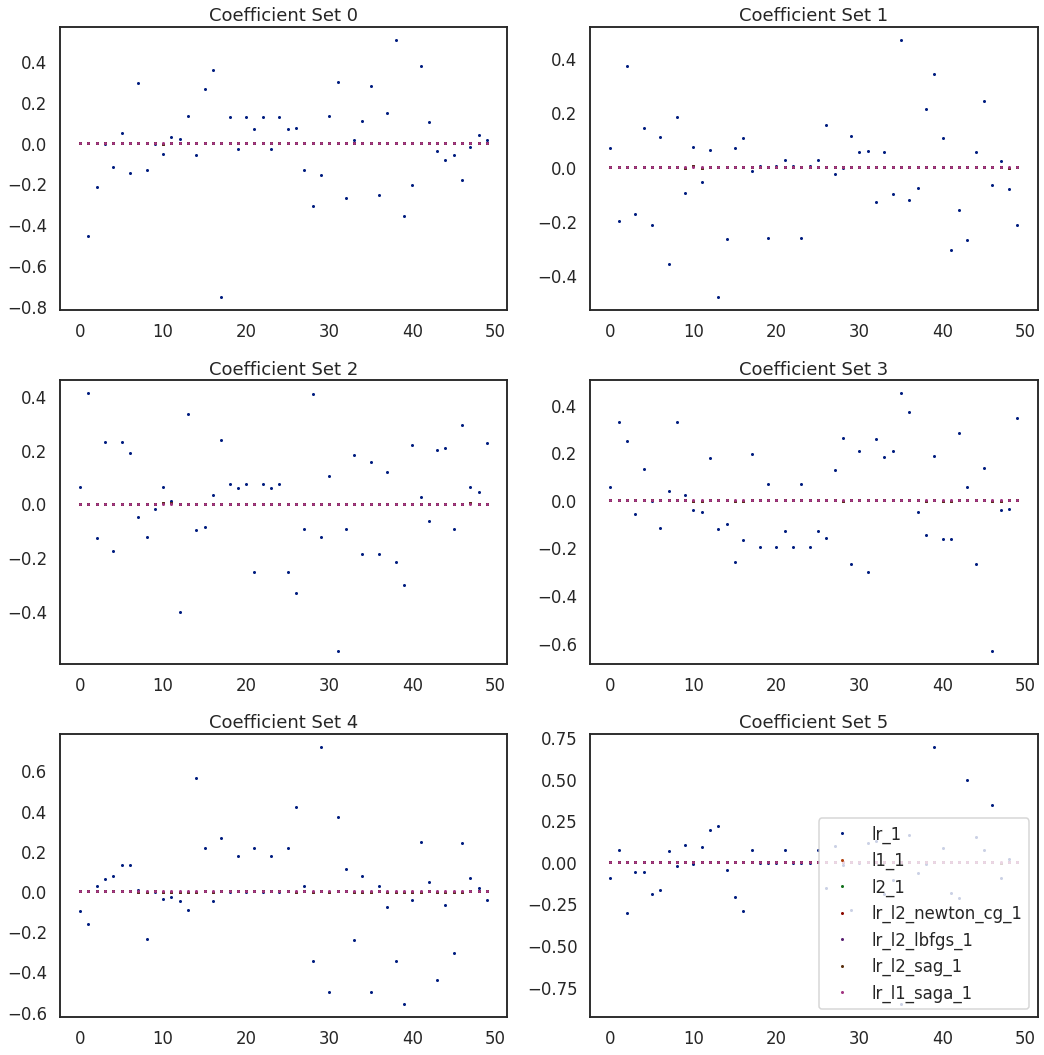

In [ ]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(15,15)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients1.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[5]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## Soru 11

* Her model için sınıfı tahmin edin ve depolayın.
* Ayrıca her bir model için öngörülen sınıf olasılığını da depolayın.

In [ ]:
# Sınıfı ve her birinin olasılığını tahmin edin

# Sınıfı ve her birinin olasılığını tahmin edin

y_pred_new = list()
y_prob_new = list()

coeff_labels_1 = ['lr_1', 'l1_1', 'l2_1','lr_l2_newton_cg_1','lr_l2_lbfgs_1','lr_l2_sag_1','lr_l1_saga_1']
coeff_models_1 = [lr_1, lr_l1_1, lr_l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1]

for lab,mod in zip(coeff_labels_1, coeff_models_1):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,lr_1,l1_1,l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


## Soru 12

Her model için aşağıdaki hata metriklerini hesaplayın:

* accuracy
* precision
* recall
* fscore
* confusion matrix

Çok modelli metrikleri her model için nasıl tek bir değerde birleştireceğinize karar verin.

In [ ]:
# Hata metriklerini yukarıda listelenen şekilde hesaplayın

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics_new = list()
cm_new = dict()

for lab in coeff_labels_1:

    # Çok sınıflı destek fonksiyonunda Precision, recall, f-score 
    precision, recall, fscore, _ = score(Y_test_new, y_pred_new[lab], average='weighted')
    
    # accuracy'yi hesaplamanın olağan yolu
    accuracy = accuracy_score(Y_test_new, y_pred_new[lab])
    
    # ROC-AUC skorları verilerin ikilileştirilmesi(binarizing) ile hesaplanabilir
    auc = roc_auc_score(label_binarize(Y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred_new[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Son olarak, confusion matrix
    cm_new[lab] = confusion_matrix(Y_test_new, y_pred_new[lab])
    
    metrics_new.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

In [ ]:
# Metrikleri çalıştırın
metrics_new

,lr_1,l1_1,l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1
precision,0.176201,0.070196,0.070196,0.070196,0.070196,0.070196,0.032891
recall,0.179029,0.183301,0.183301,0.183301,0.183301,0.183301,0.181359
fscore,0.149922,0.083673,0.083673,0.083673,0.083673,0.083673,0.055684
accuracy,0.179029,0.183301,0.183301,0.183301,0.183301,0.183301,0.181359
auc,0.500464,0.500909,0.500909,0.500909,0.500909,0.500909,0.500000


In [ ]:
type(metrics_new)

pandas.core.frame.DataFrame

## Soru 13

Her model için karışıklık matrisini görüntüleyin veya görselleştirin.

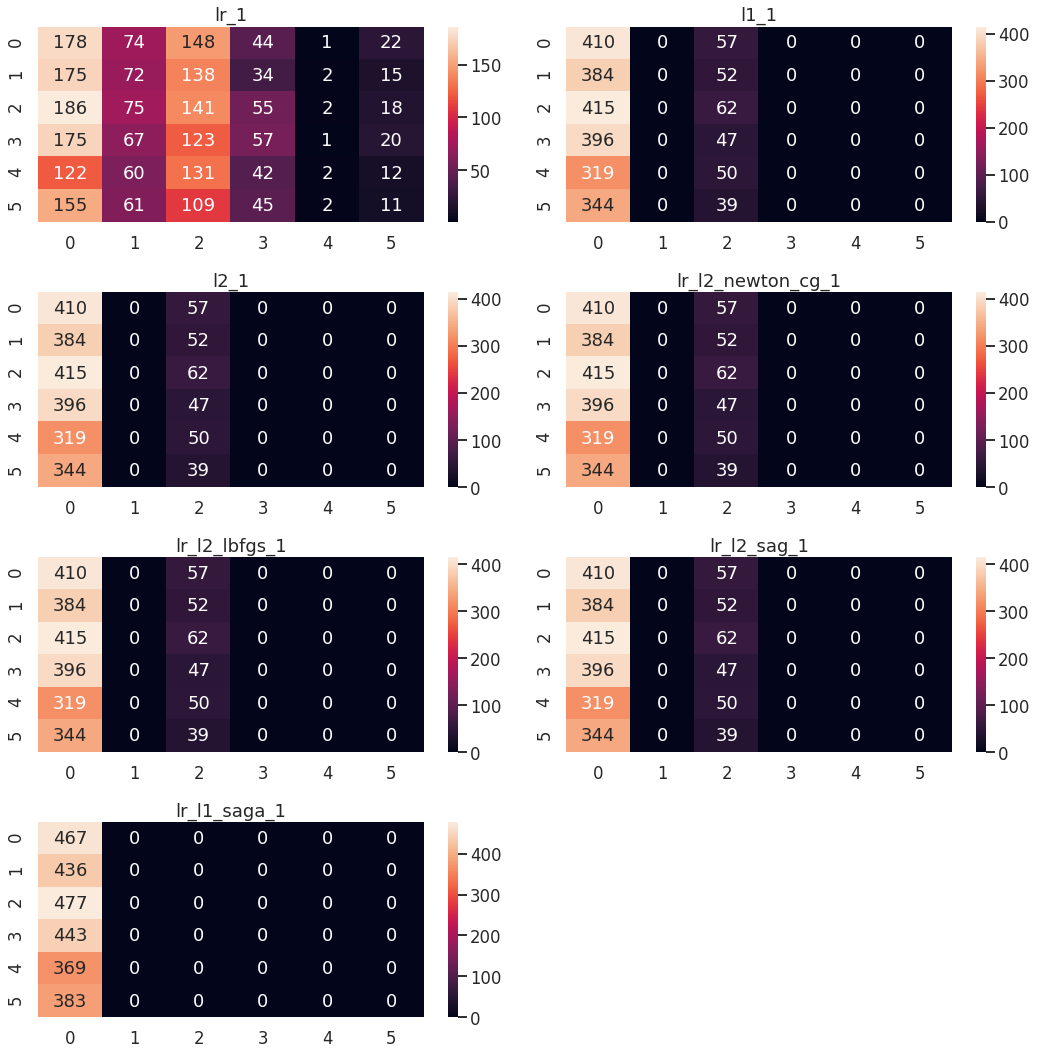

In [ ]:
# Confusion matrisini çizin


fig, axList = plt.subplots(nrows=4, ncols=2)
axList = axList.flatten()
fig.set_size_inches(15, 15)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels_1):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [ ]:
# Soru 7 ve 12 arasındaki çıktıları karşılaştırın ve gözleminizi yapın

#soru 7-----> metrics
#soru 12-----> metrics_new

frames = [metrics.T,metrics_new.T]
result = pd.concat(frames)
result=result.T
result


,lr,l1,l2,lr_l2_newton_cg,lr_l2_lbfgs,lr_l2_sag,lr_l1_saga,lr_1,l1_1,l2_1,lr_l2_newton_cg_1,lr_l2_lbfgs_1,lr_l2_sag_1,lr_l1_saga_1
precision,0.980246,0.984153,0.984806,0.983485,0.984806,0.985443,0.984133,0.176201,0.070196,0.070196,0.070196,0.070196,0.070196,0.032891
recall,0.980259,0.984142,0.984790,0.983495,0.984790,0.985437,0.984142,0.179029,0.183301,0.183301,0.183301,0.183301,0.183301,0.181359
fscore,0.980248,0.984140,0.984786,0.983488,0.984786,0.985436,0.984135,0.149922,0.083673,0.083673,0.083673,0.083673,0.083673,0.055684
accuracy,0.980259,0.984142,0.984790,0.983495,0.984790,0.985437,0.984142,0.179029,0.183301,0.183301,0.183301,0.183301,0.183301,0.181359
auc,0.988042,0.990342,0.990744,0.989983,0.990744,0.991146,0.990358,0.500464,0.500909,0.500909,0.500909,0.500909,0.500909,0.500000


In [ ]:

for lab1,lab2 in zip(coeff_labels,coeff_labels_1):
  print('[' + lab1 +" & "+lab2+']'+"======================================================================================================")
  print('')
  f = [result[lab1],result[lab2]]
  result1 = pd.concat(f,axis=1)
  print(result1)
  print('Yüksek ilişkili satırları kaldırdıktan sonra model davranışı kötüleşti ')
  print('')

[lr & lr_1]======================================================================================================

                 lr      lr_1
precision  0.980246  0.176201
recall     0.980259  0.179029
fscore     0.980248  0.149922
accuracy   0.980259  0.179029
auc        0.988042  0.500464
Yüksek ilişkili satırları kaldırdıktan sonra model davranışı kötüleşti 

[l1 & l1_1]======================================================================================================

                 l1      l1_1
precision  0.984153  0.070196
recall     0.984142  0.183301
fscore     0.984140  0.083673
accuracy   0.984142  0.183301
auc        0.990342  0.500909
Yüksek ilişkili satırları kaldırdıktan sonra model davranışı kötüleşti 

[l2 & l2_1]======================================================================================================

                 l2      l2_1
precision  0.984806  0.070196
recall     0.984790  0.183301
fscore     0.984786  0.083673
accuracy   0.984790  0.183301

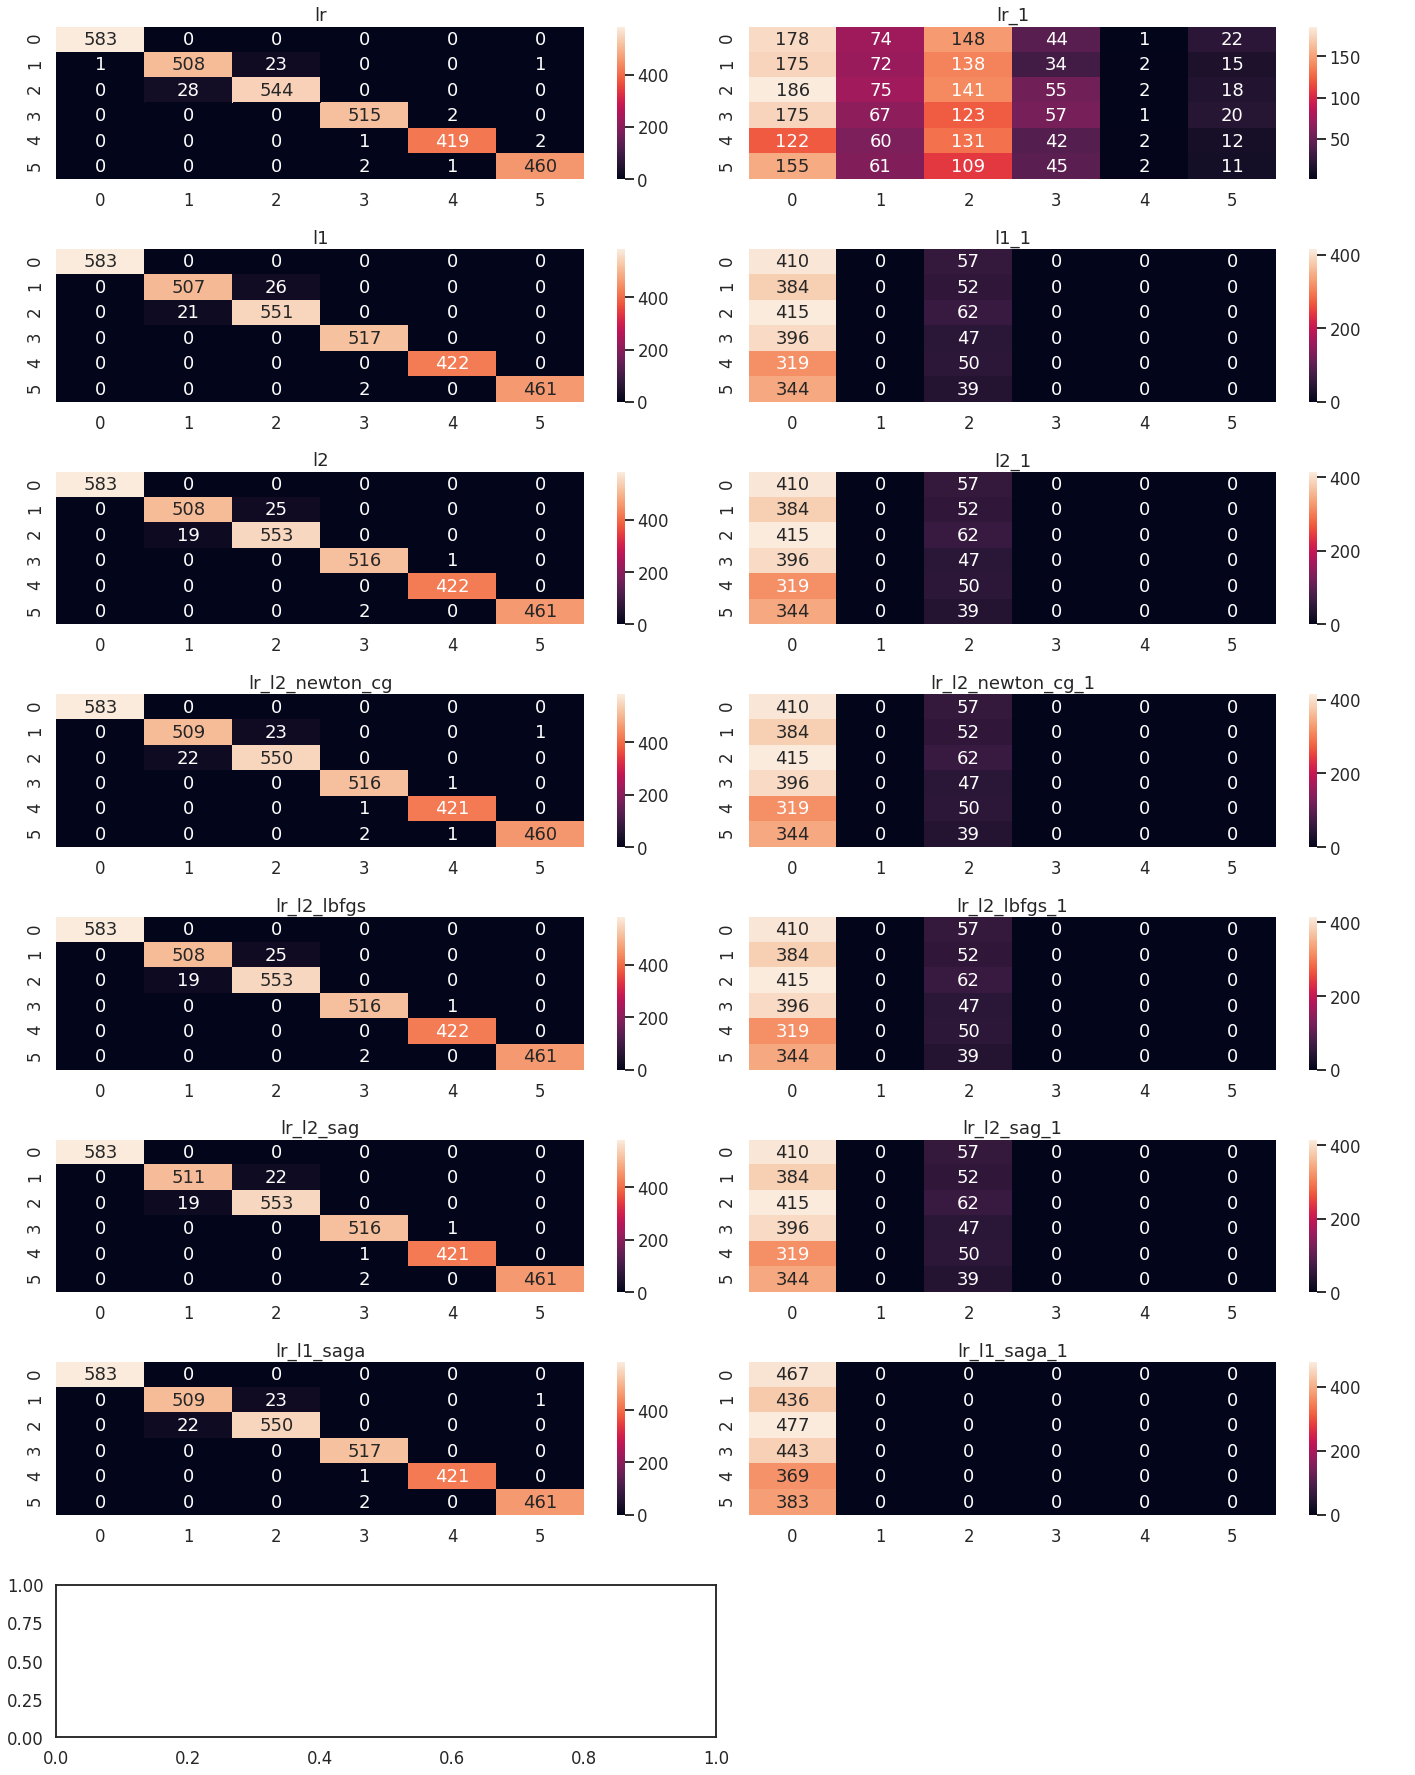

In [ ]:
# Soru 8 ve 13 arasındaki çıktıların karşılaştırmasını yapın ve gözleminizi yapın

CM = dict(list(cm.items()) + list(cm_new.items()))

#lb=coeff_labels+coeff_labels_1
lb = ['lr','lr_1', 'l1','l1_1', 'l2'  , 'l2_1'  , 'lr_l2_newton_cg', 'lr_l2_newton_cg_1' , 'lr_l2_lbfgs', 'lr_l2_lbfgs_1' , 'lr_l2_sag' , 'lr_l2_sag_1', 'lr_l1_saga', 'lr_l1_saga_1']
fig, axList = plt.subplots(nrows=8, ncols=2)
axList = axList.flatten()
fig.set_size_inches(20, 25)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], lb):
    sns.heatmap(CM[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

